In [1]:
pip install matplotlib seaborn torch torchvision scikit-learn pillow


Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install torchsummary netron


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=49ad305b19474e9ee5ddc00c107035d32f20754f394470bb1834efffb499191a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
!pip install torchsummary torchviz


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 859.0 kB/s eta 0:00:00 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=98d55410beabef5d2a6265681a1d4d3f0a3d0f0a724a909f37e85d57894bfda2
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install torchinfo



[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


DenseNet-ResNet Fusion Model Architecture
Epoch [1/10], Train Loss: 0.2035, Train Accuracy: 0.9302, Val Loss: 0.0795, Val Accuracy: 0.9711
Epoch [2/10], Train Loss: 0.0613, Train Accuracy: 0.9803, Val Loss: 0.0775, Val Accuracy: 0.9720
Epoch [3/10], Train Loss: 0.0235, Train Accuracy: 0.9926, Val Loss: 0.0706, Val Accuracy: 0.9790
Epoch [4/10], Train Loss: 0.0180, Train Accuracy: 0.9943, Val Loss: 0.0583, Val Accuracy: 0.9799
Epoch [5/10], Train Loss: 0.0061, Train Accuracy: 0.9991, Val Loss: 0.0516, Val Accuracy: 0.9843
Epoch [6/10], Train Loss: 0.0145, Train Accuracy: 0.9950, Val Loss: 0.0476, Val Accuracy: 0.9816
Epoch [7/10], Train Loss: 0.0178, Train Accuracy: 0.9952, Val Loss: 0.0879, Val Accuracy: 0.9755
Epoch [8/10], Train Loss: 0.0379, Train Accuracy: 0.9888, Val Loss: 0.0619, Val Accuracy: 0.9808
Epoch [9/10], Train Loss: 0.0287, Train Accuracy: 0.9917, Val Loss: 0.0708, Val Accuracy: 0.9764
Epoch [10/10], Train Loss: 0.0115, Train Accuracy: 0.9967, Val Loss: 0.0410, Val Accu

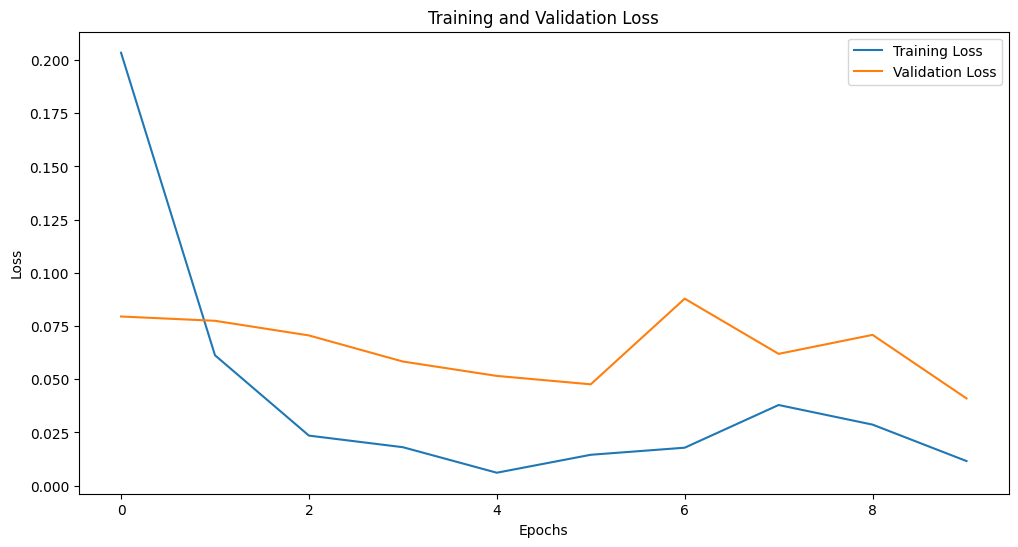

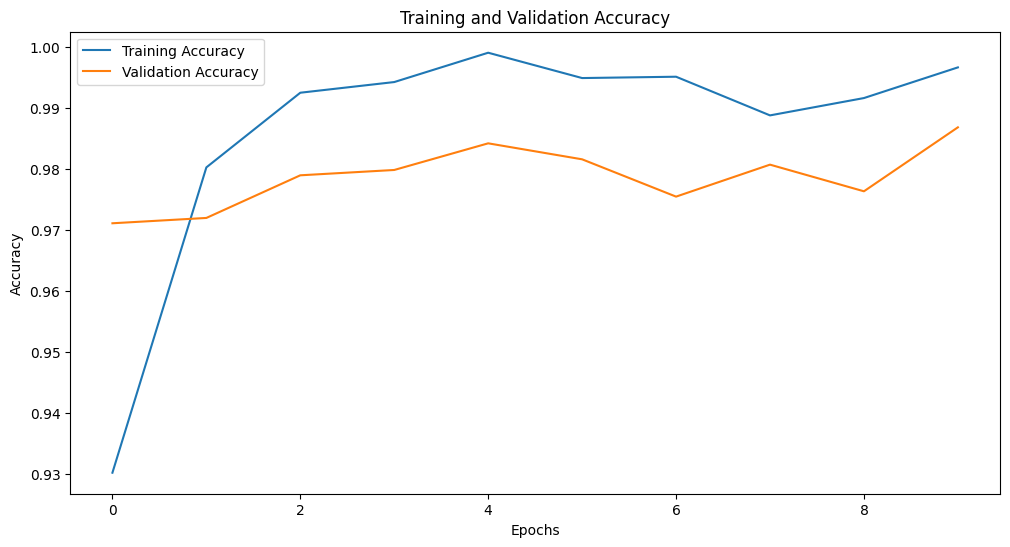

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from sklearn.metrics import accuracy_score
from PIL import Image
from torchinfo import summary

# Custom Dataset class to load and preprocess images
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.images = []
        self.labels = []
        
        for i, cls in enumerate(self.classes):
            class_dir = os.path.join(data_dir, cls)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(i)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define paths
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Training'

# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
dataset = CustomImageDataset(train_path, transform=image_transforms)

# Split the dataset into training and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the DenseNet-ResNet fusion model
class DenseNetResNetFusion(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetResNetFusion, self).__init__()
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Remove the final fully connected layers
        self.densenet.classifier = nn.Identity()
        self.resnet.fc = nn.Identity()
        
        # Fusion layer and final classifier
        self.fc_fusion = nn.Linear(1024 + 2048, num_classes)
        
    def forward(self, x):
        features_densenet = self.densenet(x)
        features_resnet = self.resnet(x)
        
        # Concatenate the features
        fused_features = torch.cat((features_densenet, features_resnet), dim=1)
        output = self.fc_fusion(fused_features)
        return output

# Initialize the model
num_classes = len(dataset.classes)
model = DenseNetResNetFusion(num_classes=num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Print model summary
print("DenseNet-ResNet Fusion Model Architecture")
summary(model, input_size=(32, 3, 224, 224))

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training and validation loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
